# Personal Activity Tracking Data Analysis
## by Ivaylo Pavlov (16/10/2016)
#### Data sources:
##### iPhone (25/09/2015 - 11/03/2016)
##### Garmin Vivosmart HR (11/03/2016 - Present)

In [57]:
#Import the libraries for Data Transformation
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as mpatches
import seaborn as sns #Wrapper Matplotlib for the TimeSeries Boxplot as pure Matplotlib is a bit painful
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the CSV file with the daily data
raw_data = pd.read_csv("Health Data-daily.csv")
raw_data.head()

#Import the CSV file with intraday data with Heath Rate data
### To be implemented at a later stage

,Start,Finish,Active Calories (kcal),Biotin (mcg),Blood Alcohol Content (%),Blood Glucose (mg/dL),Blood Pressure (Diastolic) (mmHg),Blood Pressure (Systolic) (mmHg),Body Fat Percentage (%),Body Mass Index (count),...,Vitamin B12 (mcg),Vitamin B6 (mg),Vitamin C (mg),Vitamin D (mcg),Vitamin E (mg),Vitamin K (mcg),Weight (kg),Dietary Water (L),Zinc (mg),UV Exposure (count)
0,25-Sep-2015 00:00,26-Sep-2015 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26-Sep-2015 00:00,27-Sep-2015 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27-Sep-2015 00:00,28-Sep-2015 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28-Sep-2015 00:00,29-Sep-2015 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29-Sep-2015 00:00,30-Sep-2015 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#Number of rows
raw_data.shape[0]

387

In [4]:
#Delete all the zero columns
data = raw_data.loc[:, (raw_data != 0).any(axis=0)]

#Setting Table Index
data = data.set_index(pd.DatetimeIndex(data['Start']))

#Delete the useless column
data = data.drop(['Start','Finish','Caffeine (mg)'],axis=1)

In [5]:
data.head()

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg)
2015-09-25,0.0,0.0,0.0,0.110230,1.0,0.0,0.0,0.0,130.0,0.0
2015-09-26,0.0,0.0,0.0,2.812128,1.0,0.0,0.0,0.0,3430.0,0.0
2015-09-27,0.0,0.0,0.0,8.199522,4.0,0.0,0.0,0.0,11099.0,0.0
2015-09-28,0.0,0.0,0.0,6.162432,21.0,0.0,0.0,0.0,8494.0,0.0
2015-09-29,0.0,0.0,0.0,5.719998,6.0,0.0,0.0,0.0,7810.0,0.0


In [6]:
#Remaining columns
list(data)

['Active Calories (kcal)',
 'Body Fat Percentage (%)',
 'Body Mass Index (count)',
 'Distance (km)',
 'Flights Climbed (count)',
 'Heart Rate (count/min)',
 'Lean Body Mass (kg)',
 'Resting Calories (kcal)',
 'Steps (count)',
 'Weight (kg)']

In [7]:
#Scale Body Fat Percentage (%) by 100
data.loc[:,'Body Fat Percentage (%)'] *= 100

In [8]:
#Fill previous value for the Weight-related data
data.loc[:,'Weight (kg)'] = data.loc[:,'Weight (kg)'].replace(to_replace=0, method='ffill')
data.loc[:,'Body Fat Percentage (%)'] = data.loc[:,'Body Fat Percentage (%)'].replace(to_replace=0, method='ffill')
data.loc[:,'Body Mass Index (count)'] = data.loc[:,'Body Mass Index (count)'].replace(to_replace=0, method='ffill')
data.loc[:,'Lean Body Mass (kg)'] = data.loc[:,'Lean Body Mass (kg)'].replace(to_replace=0, method='ffill')

data.tail()

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg)
2016-10-11,0.0,9.8,17.299999,7.400000,25.000000,154.0,48.428379,0.0,9205.0,53.689999
2016-10-12,0.0,9.8,17.299999,4.100000,14.000000,139.0,48.428379,0.0,5106.0,53.689999
2016-10-13,80.0,9.8,17.299999,5.823177,19.160138,0.0,48.428379,875.0,5880.0,53.689999
2016-10-14,0.0,9.8,17.299999,6.600000,12.000000,146.0,48.428379,0.0,8281.0,53.689999
2016-10-15,0.0,9.8,17.299999,0.000000,0.000000,76.0,48.428379,0.0,0.0,53.689999


In [9]:
#Setting all days with less than 200 steps as NaN, means haven't worn the tracker for the day or battery died
data.loc[data.loc[:,'Steps (count)']<200,'Steps (count)'] = np.nan

#Add a day of the week to the DataSet
data['Day'] = data.index.dayofweek

days = {0:'0 Mon',1:'1 Tue',2:'2 Weds',3:'3 Thurs',4:'4 Fri',5:'5 Sat',6:'6 Sun'}
data['Day'] = data['Day'].apply(lambda x: days[x])

In [10]:
#Display the charts in the Notebook and increase the images resolution from the default of 80 to 150
%pylab inline
plt.rc("savefig", dpi=300)
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


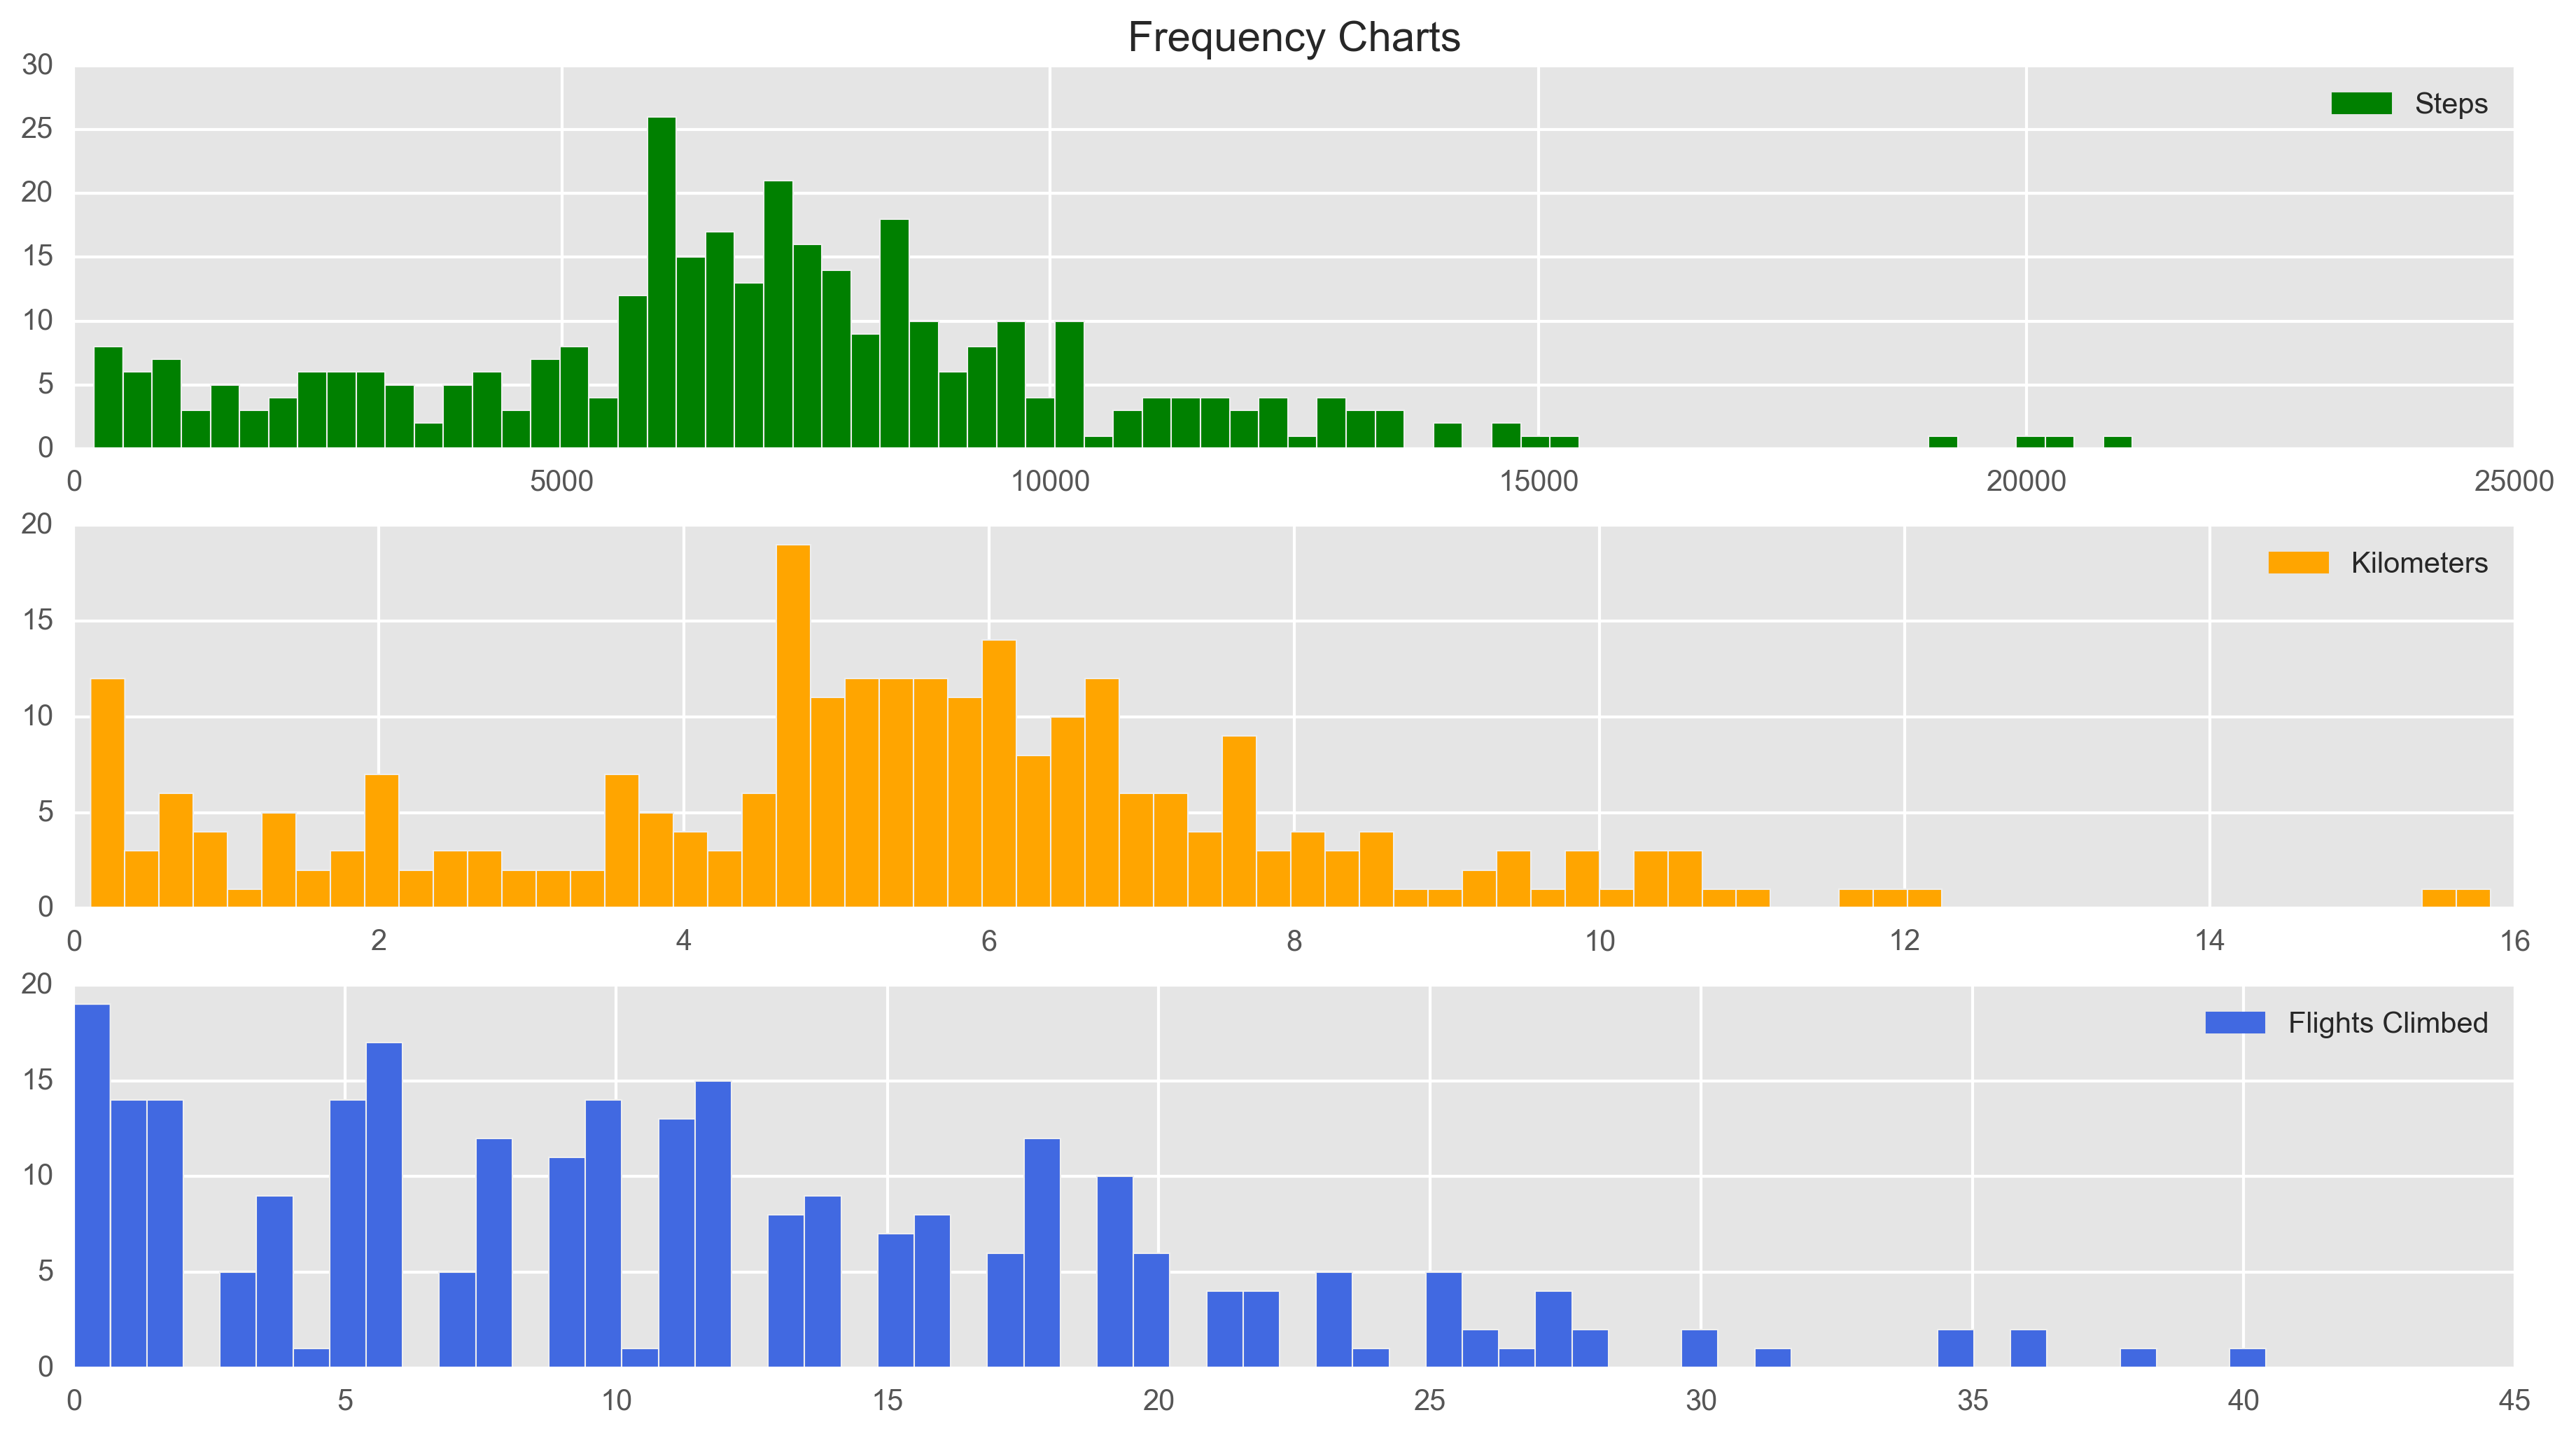

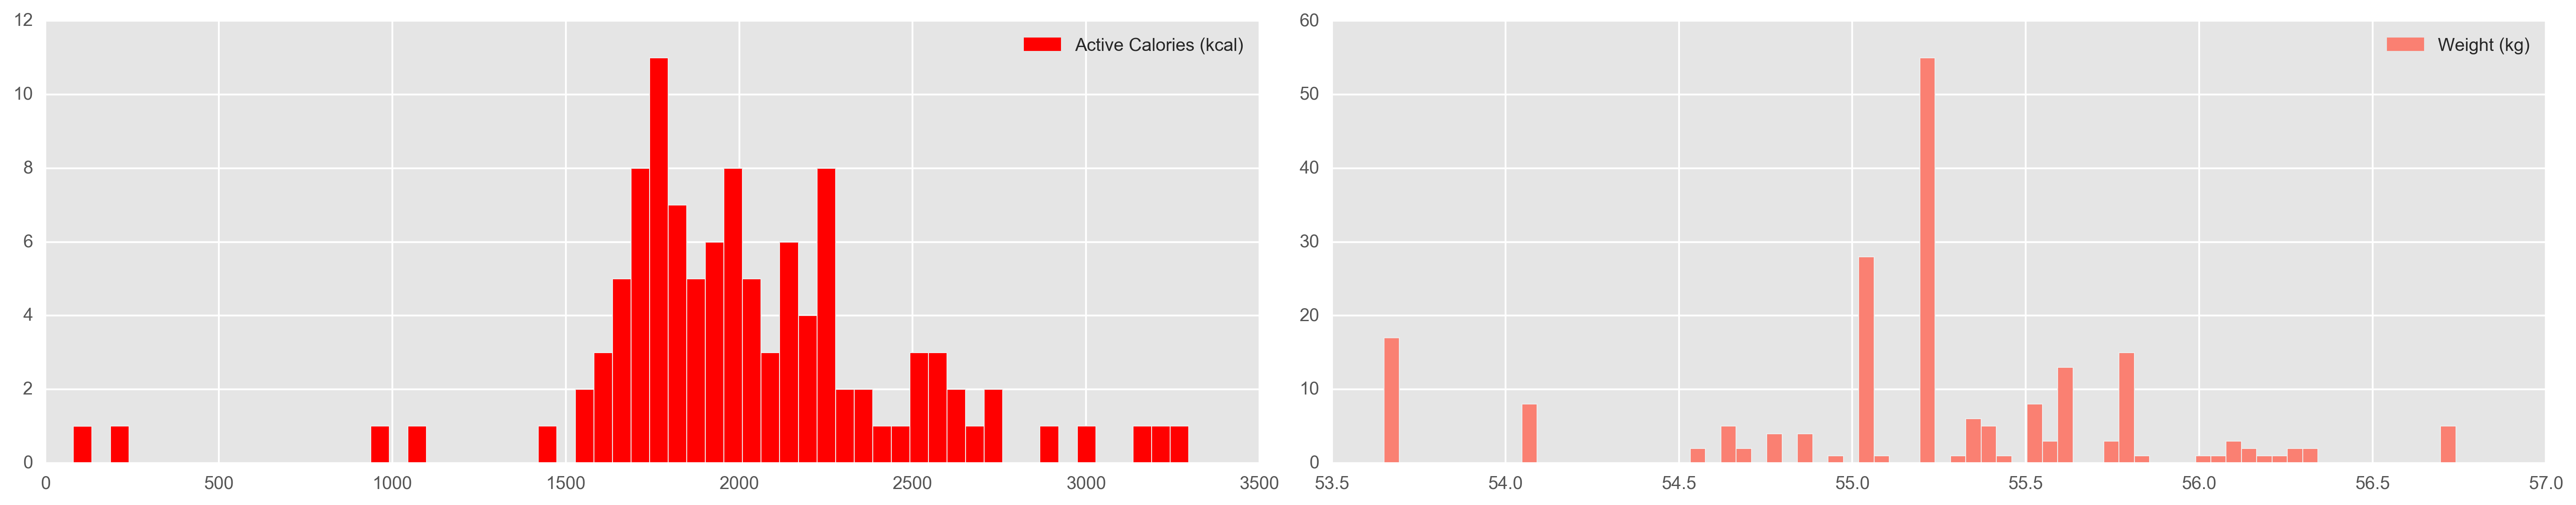

In [11]:
data_for_steps = data[np.isfinite(data['Steps (count)'])]
data_for_distance = data
data_for_cal = data

data_for_distance.loc[data_for_distance.loc[:,'Distance (km)']<0.1,'Distance (km)'] = np.nan
data_for_distance = data[np.isfinite(data['Distance (km)'])]

data_for_cal.loc[data_for_cal.loc[:,'Active Calories (kcal)']<0.1,'Active Calories (kcal)'] = np.nan
data_for_cal = data[np.isfinite(data['Active Calories (kcal)'])]

#Frequency charts of Steps & Distance (km)
plt.figure(1,figsize=(15,8))

plt.subplot(311)
plt.title('Frequency Charts')
plt.legend(handles=[mpatches.Patch(color='green', label='Steps')])
plt.hist(data_for_steps.loc[:,'Steps (count)'], bins=70, color='g')

plt.subplot(312)
plt.legend(handles=[mpatches.Patch(color='orange', label='Kilometers')])
plt.hist(data_for_distance.loc[:,'Distance (km)'], bins=70, color='orange')

plt.subplot(313)
plt.legend(handles=[mpatches.Patch(color='royalblue', label='Flights Climbed')])
plt.hist(data_for_distance.loc[:,'Flights Climbed (count)'], bins=60, color='royalblue')

plt.figure(2,figsize=(20,4))
plt.subplot(121)
plt.legend(handles=[mpatches.Patch(color='red', label='Active Calories (kcal)')])
plt.hist(data_for_cal.loc[:,'Active Calories (kcal)'], bins=60, color='red')

plt.subplot(122)
data_for_weight = data[np.isfinite(data['Weight (kg)'])]
data_for_weight = data_for_weight.ix[:,['Weight (kg)']]
data_for_weight = data_for_weight.ix[data_for_weight.index>'2016-03-28']
plt.legend(handles=[mpatches.Patch(color='salmon', label='Weight (kg)')])
plt.hist(data_for_weight.loc[:,'Weight (kg)'], bins=70, color='salmon')

plt.tight_layout()
plt.show()

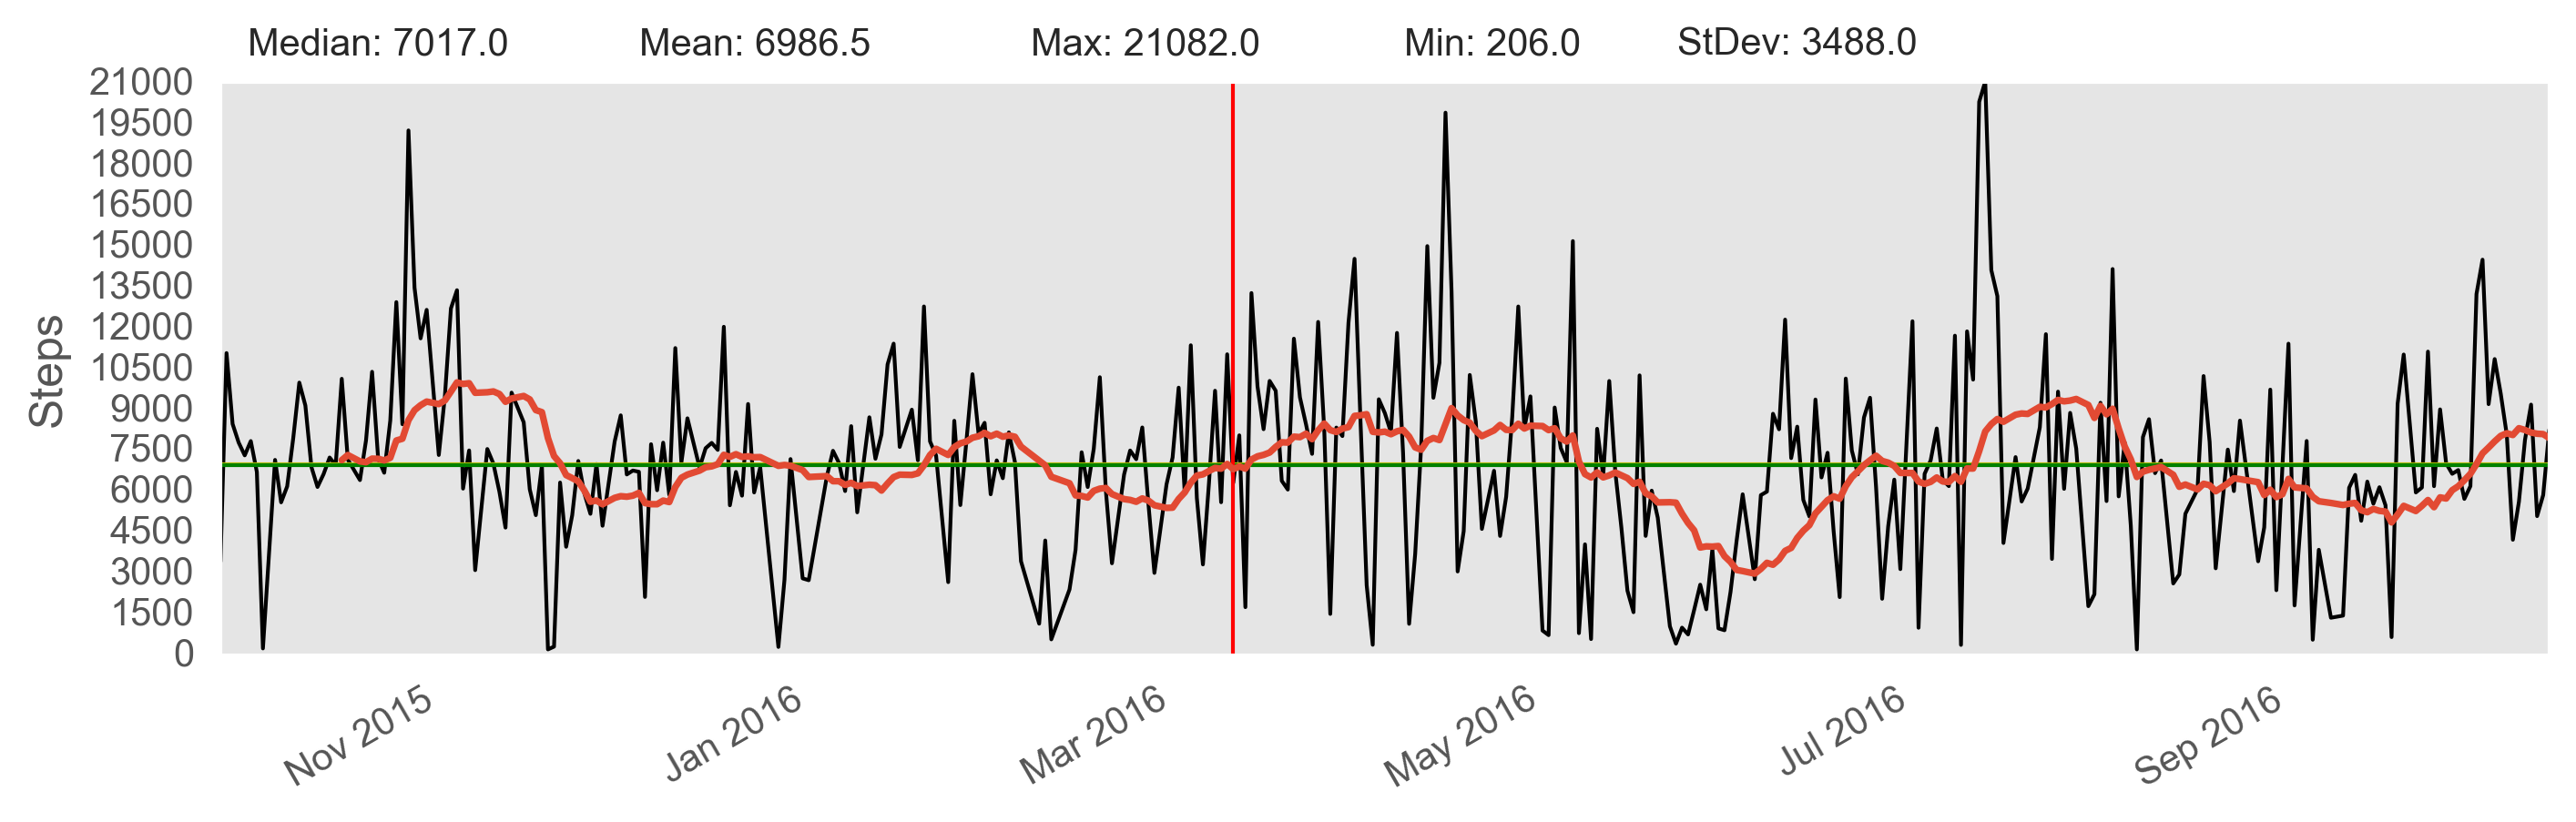

In [12]:
#calculate stats
medianval = np.round(data_for_steps.loc[:,'Steps (count)'].median(),1)
avgval = np.round(data_for_steps.loc[:,'Steps (count)'].mean(),1)
maxval = np.round(data_for_steps.loc[:,'Steps (count)'].max(),1)
stdval = np.round(data_for_steps.loc[:,'Steps (count)'].std(),1)
minval = np.round(data_for_steps.loc[:,'Steps (count)'].min(),1)

minor_ticks = np.arange(0, maxval+1, 1500, dtype=int)
minor_labels = minor_ticks

ax1 = data_for_steps.loc[:,'Steps (count)'].plot(color='000000',figsize=(11, 3),linewidth=1.0)

ax1.set_ylim(0,maxval)
ax1.set_ylabel('Steps')
ax1.set_yticks(minor_ticks)
ax1.set_yticklabels(minor_labels)

ax1.set_xticks(data_for_steps.index, minor=True)
#Add the horizontal and vertical lines
ax1.axhline(y=medianval, linewidth=1, color='y')
ax1.axhline(y=avgval, linewidth=1, color='g')
ax1.axvline(x='2016-03-11', linewidth=1, color='r')
ax1.grid(b=False)

#Add the stats labels for Steps
ax1.annotate('Median: '+str(medianval), xy=(30,660),xycoords='axes pixels' )
ax1.annotate('Mean: '+str(avgval), xy=(460,660),xycoords='axes pixels' )
ax1.annotate('Max: '+str(maxval), xy=(890,660),xycoords='axes pixels' )
ax1.annotate('Min: '+str(minval), xy=(1300,660),xycoords='axes pixels' )
ax1.annotate('StDev: '+str(stdval), xy=(1600,660),xycoords='axes pixels' )

#Rolling 20 Day MA
ma = data_for_steps.loc[:,'Steps (count)'].rolling(20).mean()
ax1.plot(ma)

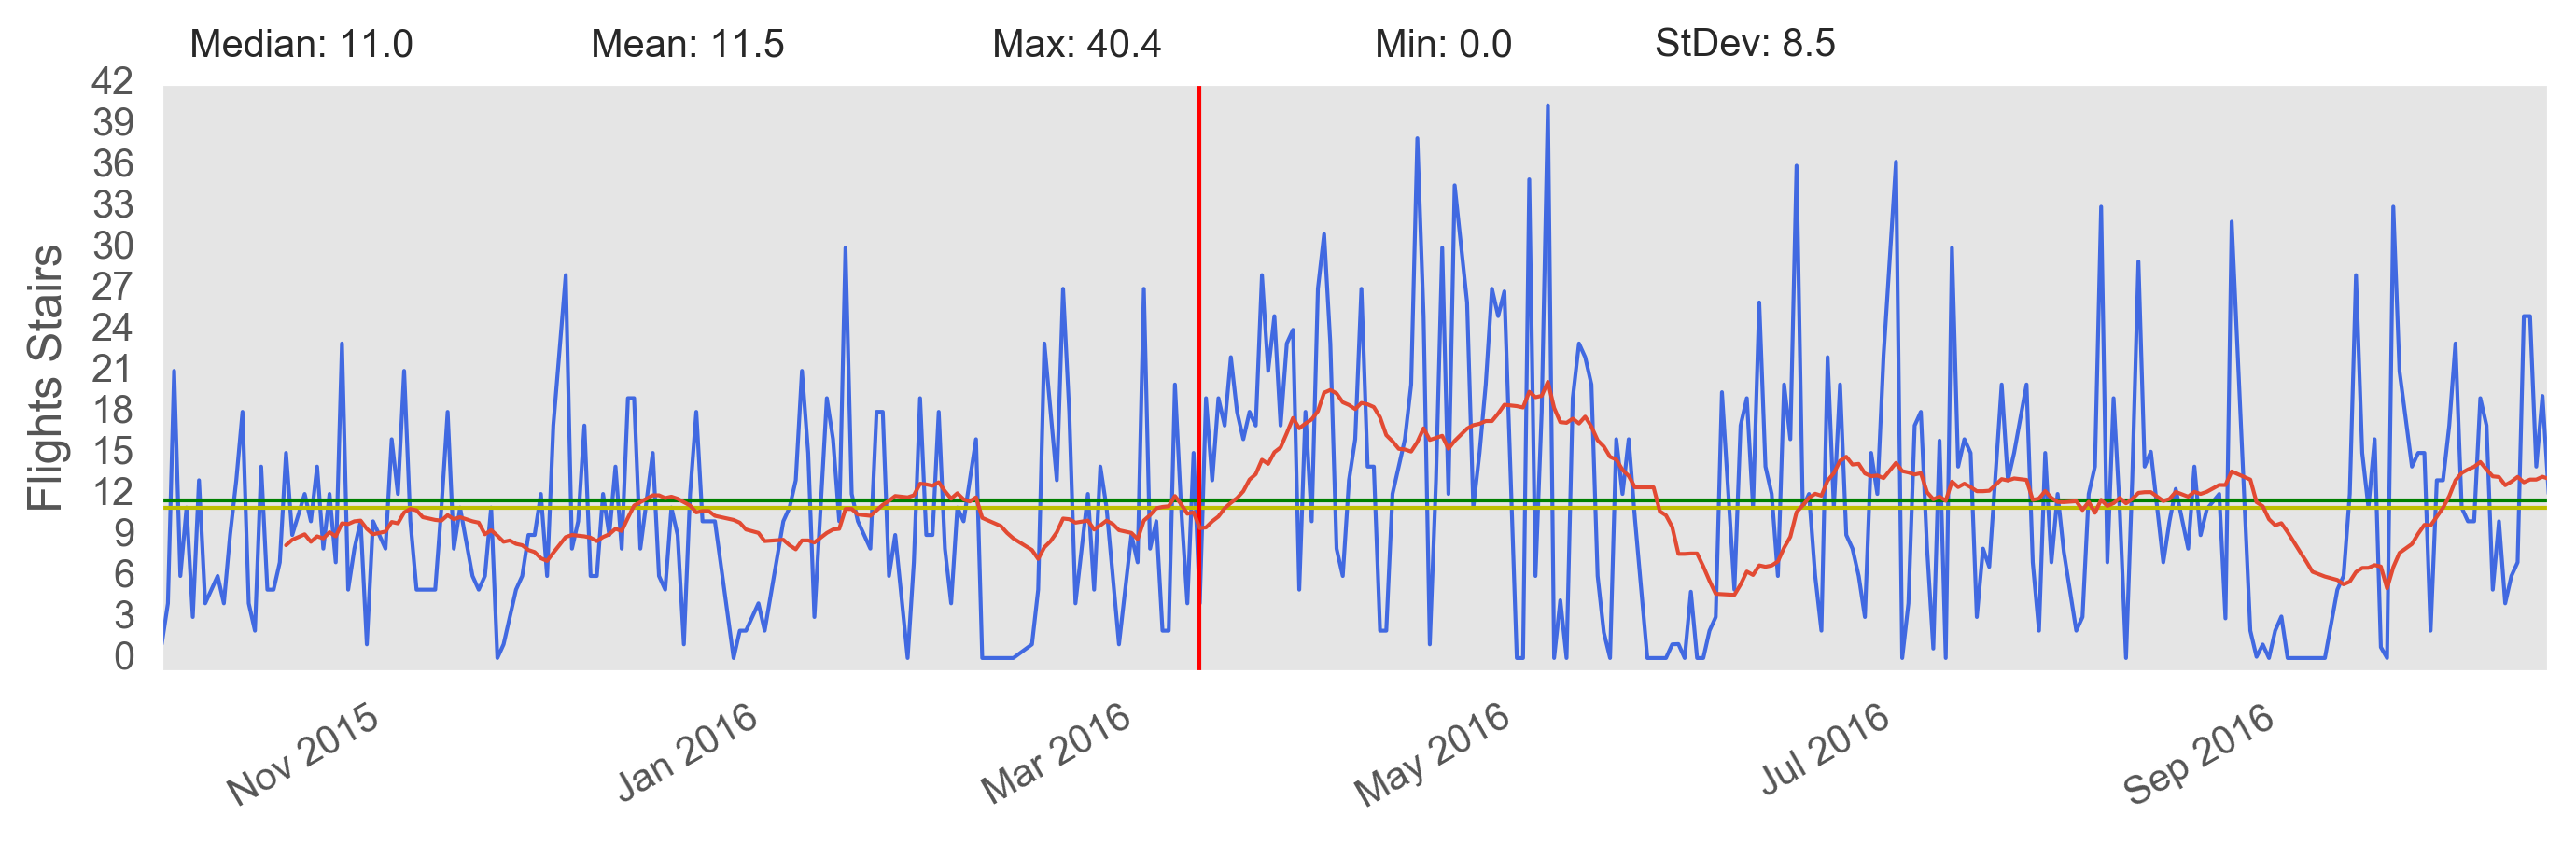

In [13]:
## Stairs chart
#calculate stats
medianval2 = np.round(data_for_steps.loc[:,'Flights Climbed (count)'].median(),1)
avgval2 = np.round(data_for_steps.loc[:,'Flights Climbed (count)'].mean(),1)
maxval2 = np.round(data_for_steps.loc[:,'Flights Climbed (count)'].max(),1)
stdval2 = np.round(data_for_steps.loc[:,'Flights Climbed (count)'].std(),1)
minval2 = np.round(data_for_steps.loc[:,'Flights Climbed (count)'].min(),1)

minor_ticks_stairs = np.arange(0, maxval2+2, 3, dtype=int)
minor_labels_stairs = minor_ticks_stairs

ax2 = data_for_steps.loc[:,'Flights Climbed (count)'].plot(color='royalblue',figsize=(11, 3),linewidth=1.0)

ax2.set_ylim(-1,maxval2)
ax2.set_ylabel('Flights Stairs')
ax2.set_yticks(minor_ticks_stairs)
ax2.set_yticklabels(minor_labels_stairs)

#Add the horizontal and vertical lines
ax2.axhline(y=medianval2, linewidth=1, color='y')
ax2.axhline(y=avgval2, linewidth=1, color='g')
ax2.axvline(x='2016-03-11', linewidth=1, color='r')
ax2.grid(b=False)

#Add the stats labels for Steps
ax2.annotate('Median: '+str(medianval2), xy=(30,660),xycoords='axes pixels' )
ax2.annotate('Mean: '+str(avgval2), xy=(460,660),xycoords='axes pixels' )
ax2.annotate('Max: '+str(maxval2), xy=(890,660),xycoords='axes pixels' )
ax2.annotate('Min: '+str(minval2), xy=(1300,660),xycoords='axes pixels' )
ax2.annotate('StDev: '+str(stdval2), xy=(1600,660),xycoords='axes pixels' )

#Rolling 20 Day MA
ma2 = data_for_steps.loc[:,'Flights Climbed (count)'].rolling(20).mean()
ax2.plot(ma2,linewidth=1.0)

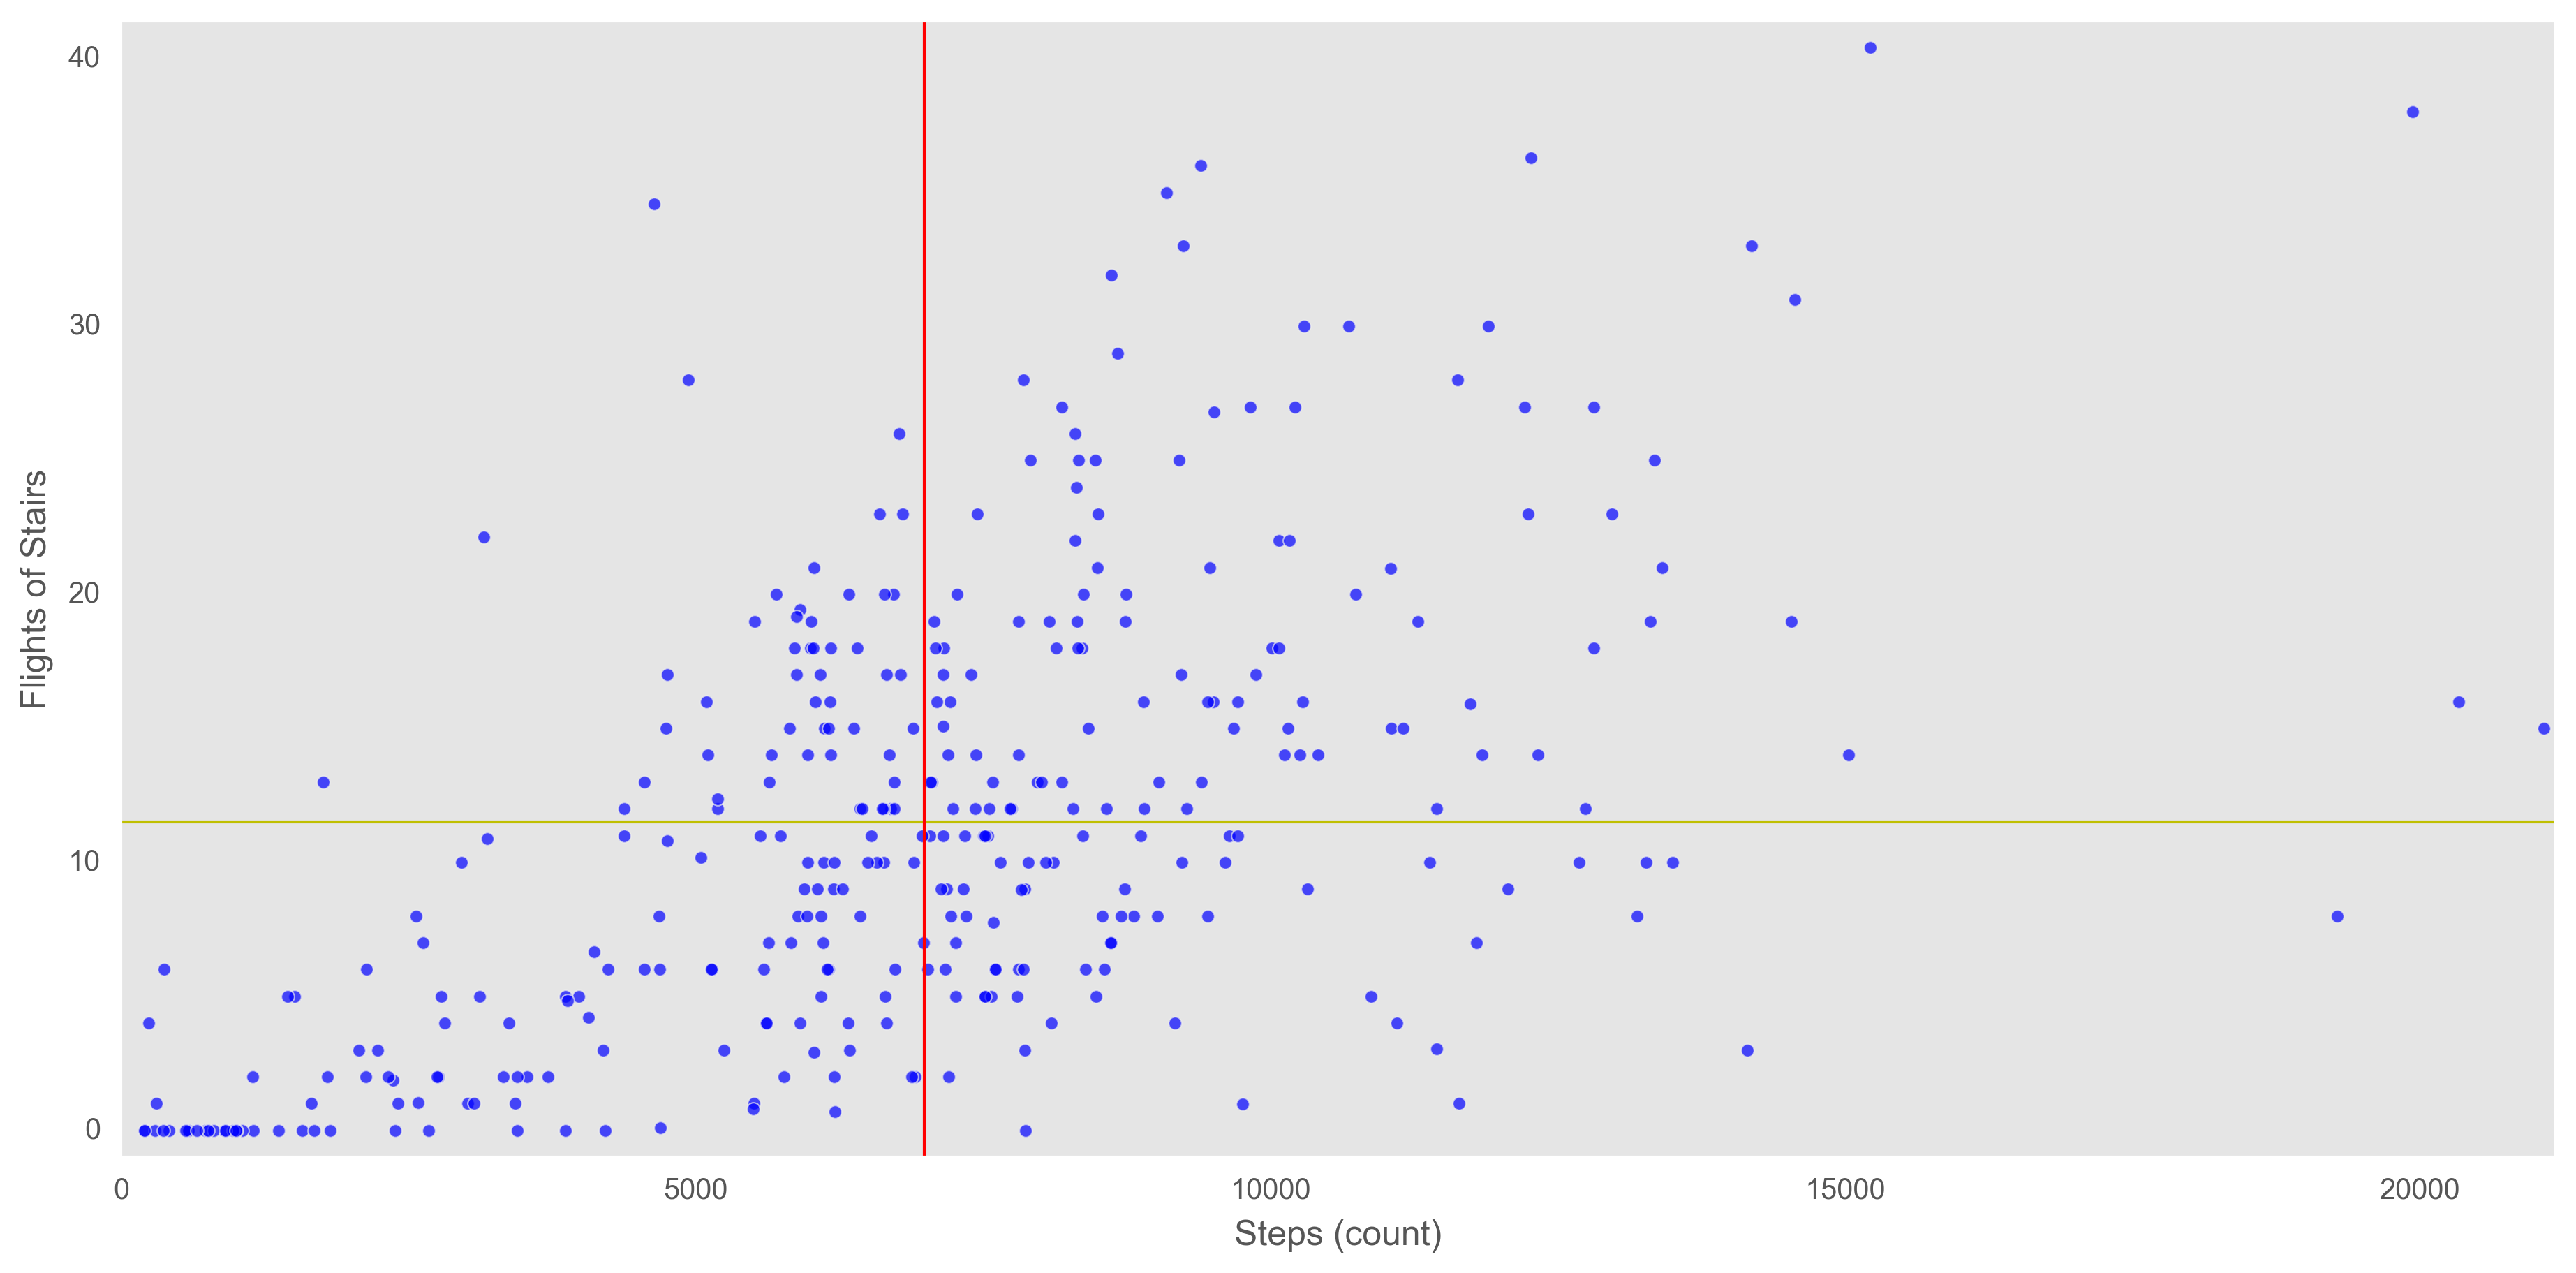

In [14]:
#Scatter chart Steps vs Stairs
plt.figure(1,figsize=(15,7))

x = data_for_steps.ix[:,'Steps (count)']
y = data_for_steps.ix[:,'Flights Climbed (count)']
plt.xlabel('Steps (count)')
plt.ylabel('Flights of Stairs')
plt.xlim(-1,data_for_steps.ix[:,'Steps (count)'].max()+100)
plt.ylim(-1,data_for_steps.ix[:,'Flights Climbed (count)'].max()+1)
plt.grid(b=False)
plt.axhline(y=avgval2, linewidth=1, color='y')
plt.axvline(x=avgval, linewidth=1, color='r')

plt.scatter(x, y, alpha=0.7)
plt.show()

##### Most active day ever by number of climbed stairs

In [15]:
data_for_steps.ix[data_for_steps['Flights Climbed (count)']==data_for_steps['Flights Climbed (count)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Day
2016-05-06,2039.0,12.3,18.0,12.07,40.4134,115.0,48.91029,0.0,15216.0,55.77,4 Fri


##### Most active day ever by number of steps

In [16]:
data_for_steps.ix[data_for_steps['Steps (count)']==data_for_steps['Steps (count)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Day
2016-07-13,0.0,10.3,17.8,0.0,15.0,128.0,49.37088,0.0,21082.0,55.04,2 Weds


##### Most active day ever by distance done

In [17]:
data_for_steps.ix[data_for_steps['Distance (km)']==data_for_steps['Distance (km)'].max()]

,Active Calories (kcal),Body Fat Percentage (%),Body Mass Index (count),Distance (km),Flights Climbed (count),Heart Rate (count/min),Lean Body Mass (kg),Resting Calories (kcal),Steps (count),Weight (kg),Day
2016-04-15,2362.0,12.2,17.9,15.84,38.0,144.0,48.58852,0.0,19937.0,55.34,4 Fri


#### Weight, Lean Body Mass and Body Fat % Analysis

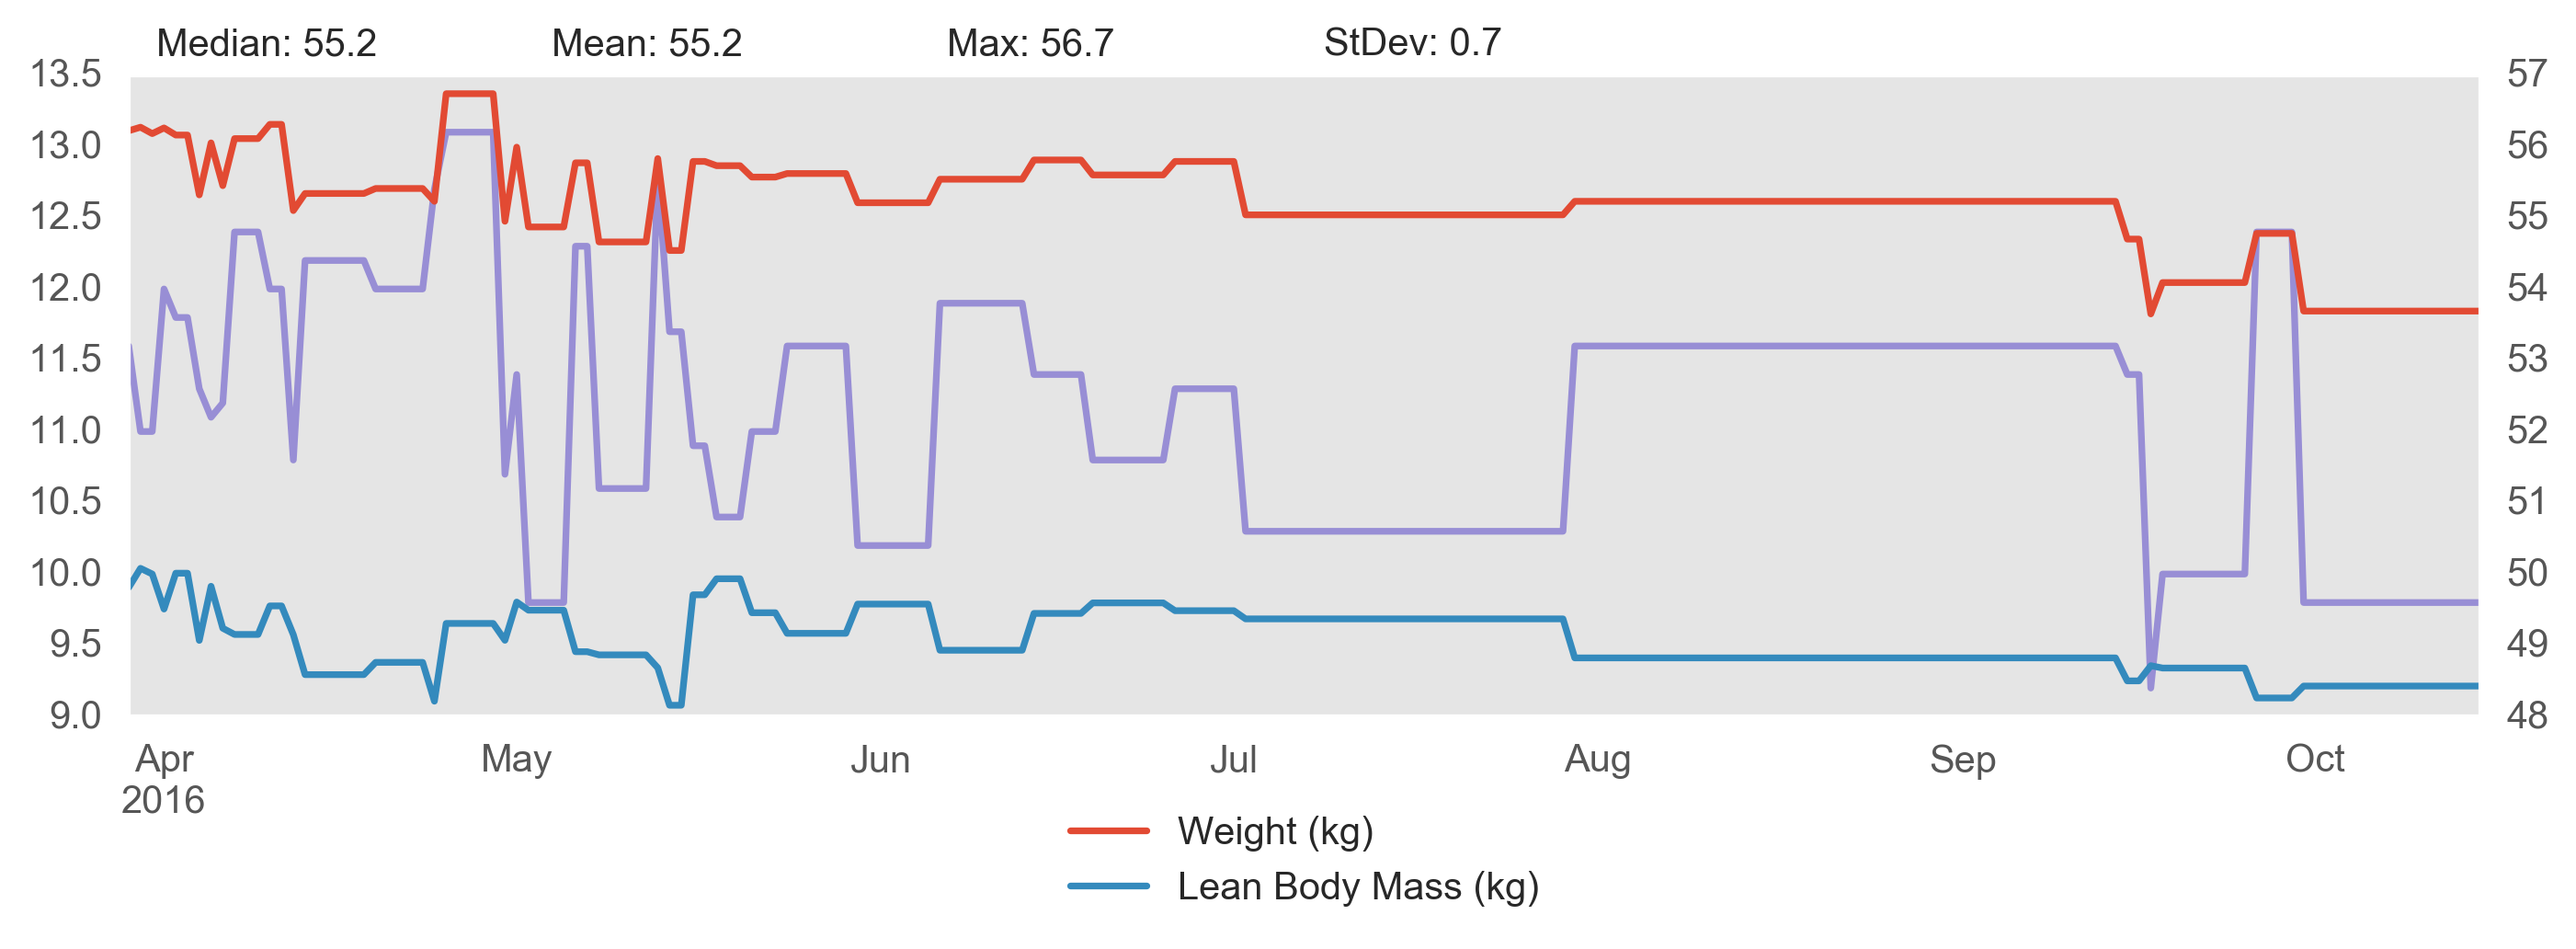

In [18]:
#remove NA rows only for this chart and plot the weight and lean body mass
data_for_weight = data[np.isfinite(data['Weight (kg)'])]
data_for_weight = data_for_weight.ix[:,['Weight (kg)','Lean Body Mass (kg)','Body Fat Percentage (%)']]
data_for_weight = data_for_weight.ix[data_for_weight.index>'2016-03-28']

#calculate stats
medianval3 = np.round(data_for_weight.loc[:,'Weight (kg)'].median(),1)
avgval3 = np.round(data_for_weight.loc[:,'Weight (kg)'].mean(),1)
maxval3 = np.round(data_for_weight.loc[:,'Weight (kg)'].max(),1)
stdval3 = np.round(data_for_weight.loc[:,'Weight (kg)'].std(),1)

minor_ticks_weight = np.arange(data_for_weight['Lean Body Mass (kg)'].min(), data_for_weight['Weight (kg)'].max()+1, 1, dtype=int)
minor_labels_weight = minor_ticks_weight

ax3 = data_for_weight['Weight (kg)'].plot(secondary_y=True,figsize=(11, 3));
ax3 = data_for_weight['Lean Body Mass (kg)'].plot(secondary_y=True,figsize=(11, 3));
ax4 = data_for_weight['Body Fat Percentage (%)'].plot(figsize=(11, 3))
ax3.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=1)
ax3.grid(b=False)
ax4.grid(b=False)

ax3.set_ylim(data_for_weight['Lean Body Mass (kg)'].min(),maxval3)
ax3.set_yticks(minor_ticks_weight)
ax3.set_yticklabels(minor_labels_weight)


#Add the stats labels for Steps
ax3.annotate('Median: '+str(medianval3), xy=(30,720),xycoords='axes pixels' )
ax3.annotate('Mean: '+str(avgval3), xy=(460,720),xycoords='axes pixels' )
ax3.annotate('Max: '+str(maxval3), xy=(890,720),xycoords='axes pixels' )
ax3.annotate('StDev: '+str(stdval3), xy=(1300,720),xycoords='axes pixels' )


In [19]:
#Averages, Medians, High, Low per day of the week
data_for_weekday = data.drop(['Body Fat Percentage (%)','Body Mass Index (count)','Lean Body Mass (kg)','Weight (kg)'],axis=1)
data_for_weekday.groupby('Day').agg(['mean','median','min','max','std'])

Active Calories (kcal)                                           \
                          mean  median          min     max         std   
Day                                                                       
0 Mon              2054.437500  1996.0  1566.000000  3296.0  476.486861   
1 Tue              2119.933333  2185.0  1688.000000  2579.0  308.636510   
2 Weds             1970.809722  2058.0   953.145823  2619.0  417.539013   
3 Thurs            1852.060048  1841.0    80.000000  3223.0  774.893704   
4 Fri              2067.223955  2022.0  1062.000000  2871.0  406.656683   
5 Sat              2143.846154  1999.0  1551.000000  3137.0  470.754509   
6 Sun              1931.875000  1847.5  1625.000000  2502.0  268.420534   

        Distance (km)                                              ...       \
                 mean    median       min        max       std     ...        
Day                                                                ...        
0 Mon        5.047830  5.213955  0.350000  10.654000  2.371298     ...        
1 Tue        6.227055  6.001151  0.740000  15.466486  2.540416     ...        
2 Weds       6.024958  5.838520  0.484112  10.897970  2.364667     ...        
3 Thurs      6.042140  5.830752  0.181440  11.625000  2.295016     ...        
4 Fri        6.314258  6.104866  0.110230  15.840000  3.180785     ...        
5 Sat        3.954463  3.700000  0.112780  10.810000  2.503731     ...        
6 Sun        3.244395  2.721215  0.119469  10.605173  2.559715     ...        

        Resting Calories (kcal)                                 Steps (count)  \
                           mean median  min     max         std          mean   
Day                                                                             
0 Mon                  0.000000    0.0  0.0     0.0    0.000000   6834.636364   
1 Tue                  0.000000    0.0  0.0     0.0    0.000000   7818.907407   
2 Weds                14.363636    0.0  0.0   790.0  106.523578   7882.653846   
3 Thurs               65.000000    0.0  0.0  1356.0  278.166018   7623.588235   
4 Fri                 23.392857    0.0  0.0  1310.0  175.056113   8271.041667   
5 Sat                  0.000000    0.0  0.0     0.0    0.000000   5079.244444   
6 Sun                  0.000000    0.0  0.0     0.0    0.000000   4807.642857   

                                              
         median    min      max          std  
Day                                           
0 Mon    7155.0  417.0  14533.0  3067.527098  
1 Tue    7512.0  910.0  20337.0  3433.567924  
2 Weds   7299.5  575.0  21082.0  3411.946089  
3 Thurs  7222.0  206.0  14565.0  2970.829205  
4 Fri    7820.5  308.0  19937.0  3544.125214  
5 Sat    4751.0  242.0  13339.0  3129.851856  
6 Sun    3932.5  206.0  13269.0  3409.838111  

[7 rows x 30 columns]

#### Heart Rate Data Analysis

In [20]:
#Get intraday data for Heart Rate measurement min/max/average and boxplot
hr = pd.read_csv('Health Data-intraday.csv')
hr.index = hr['Start']
hr = hr.ix[:,'Heart Rate (count/min)']
hr = pd.DataFrame(hr)
hr.index = pd.to_datetime(hr.index)
hr = hr.ix[hr.index>'11-Mar-2016 18:00']
hr = hr.replace(0, np.nan)
hr = hr.dropna(axis=0)
hr2 = hr
hr2['Date'] = hr2.index.date
#Data Clean
hr3 = hr2
hr3.index = hr3['Date']
hr3.head()

,Heart Rate (count/min),Date
Date,,
2016-03-11,175.0,2016-03-11
2016-03-11,56.0,2016-03-11
2016-03-12,49.0,2016-03-12
2016-03-12,132.0,2016-03-12
2016-03-13,66.0,2016-03-13


[]

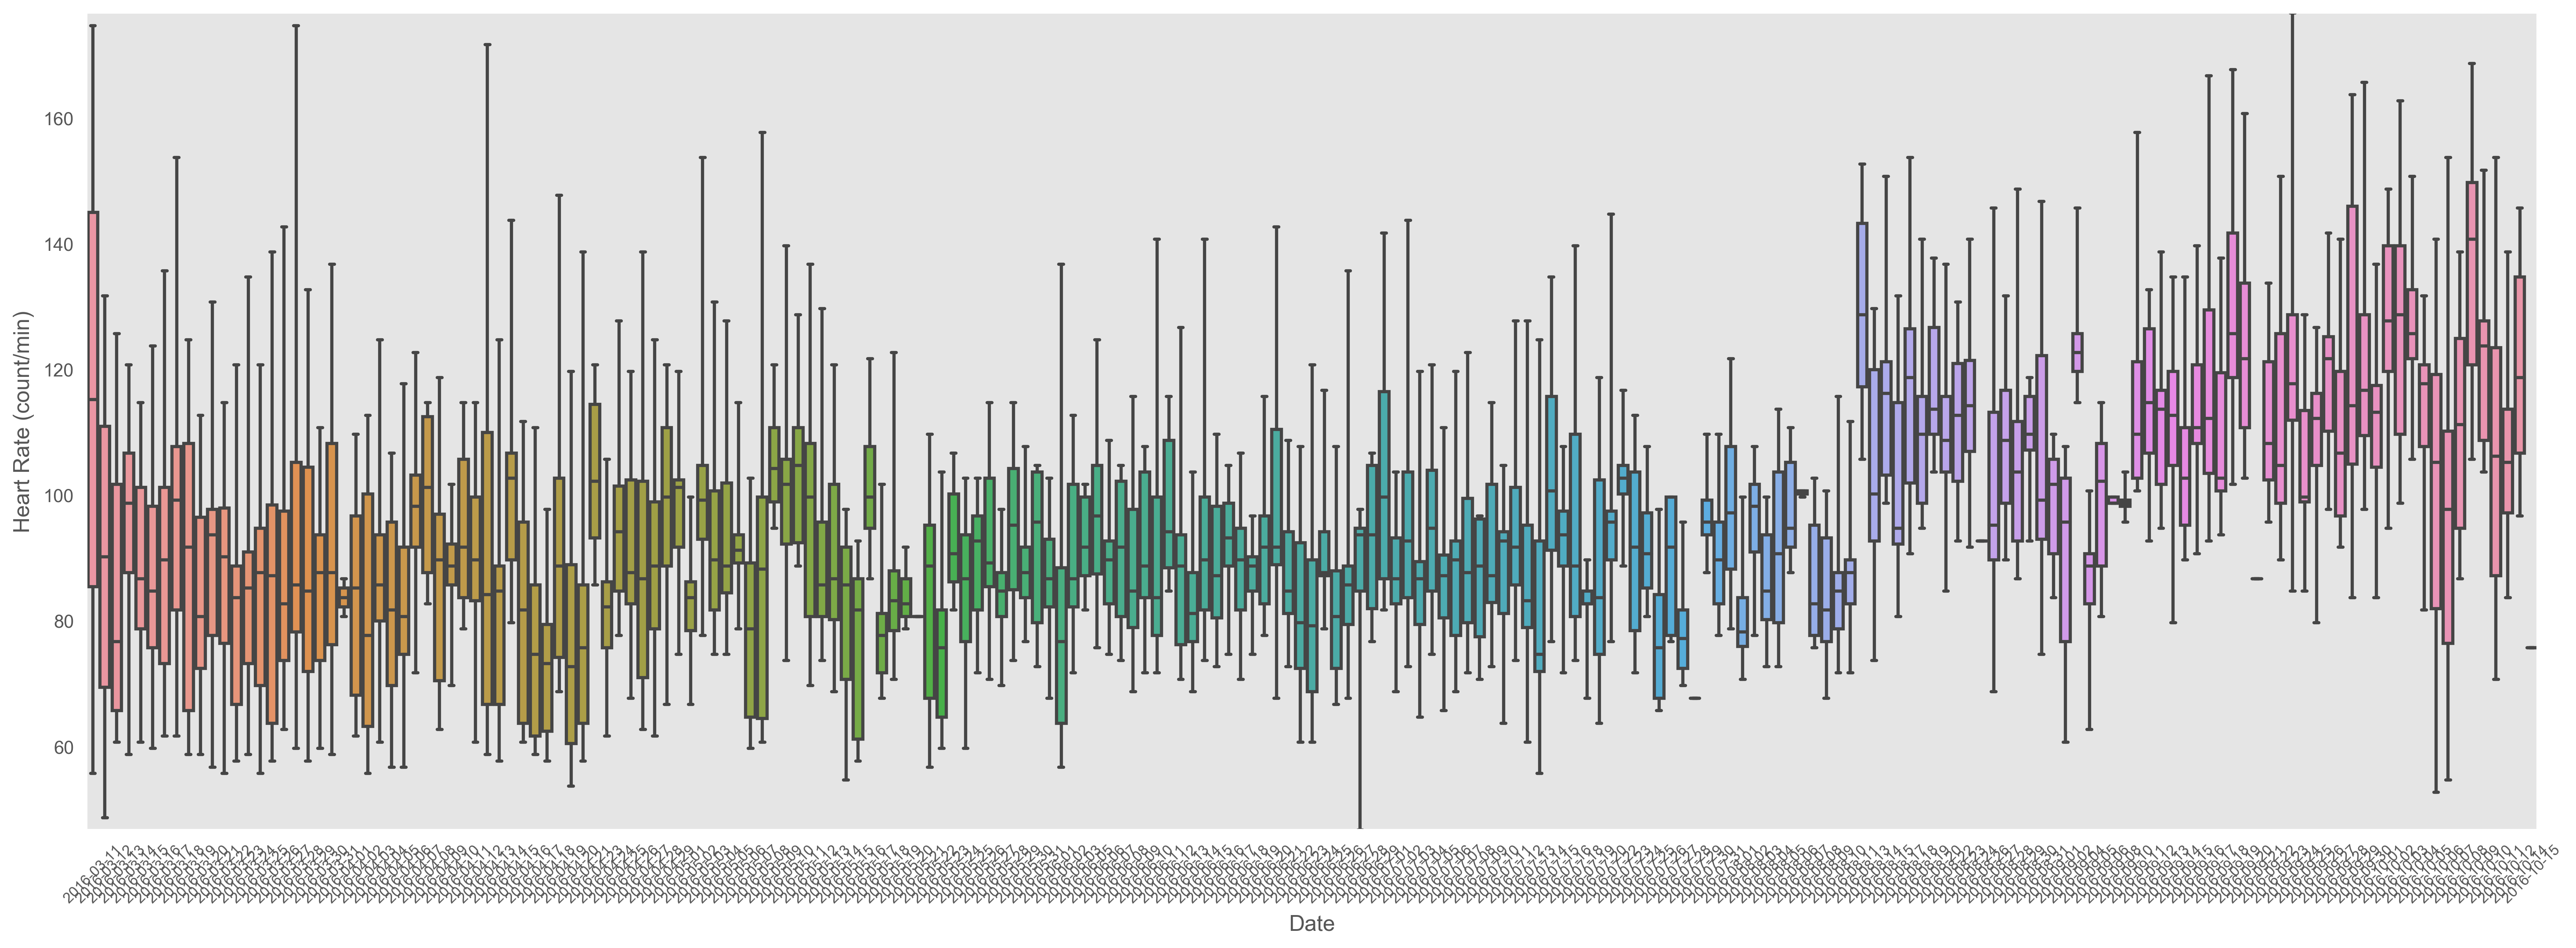

In [21]:
#Box Plot for Heart Rate Data 
plt.figure(figsize=(24,8))
ax5 = sns.boxplot(x="Date", y="Heart Rate (count/min)", data=hr3, whis=[0,100])
ax5.set_ylim(hr3['Heart Rate (count/min)'].min(),hr3['Heart Rate (count/min)'].max())
#a = pd.date_range(start="2016-03-11",end=hr3['Date'].max(),freq='D').to_pydatetime()
ax5.set_xticklabels(hr3['Date'].unique())
ax5.grid(b=False)
labels = ax5.get_xticklabels()
plt.setp(labels, rotation=45, fontsize=8)
ax5.plot()

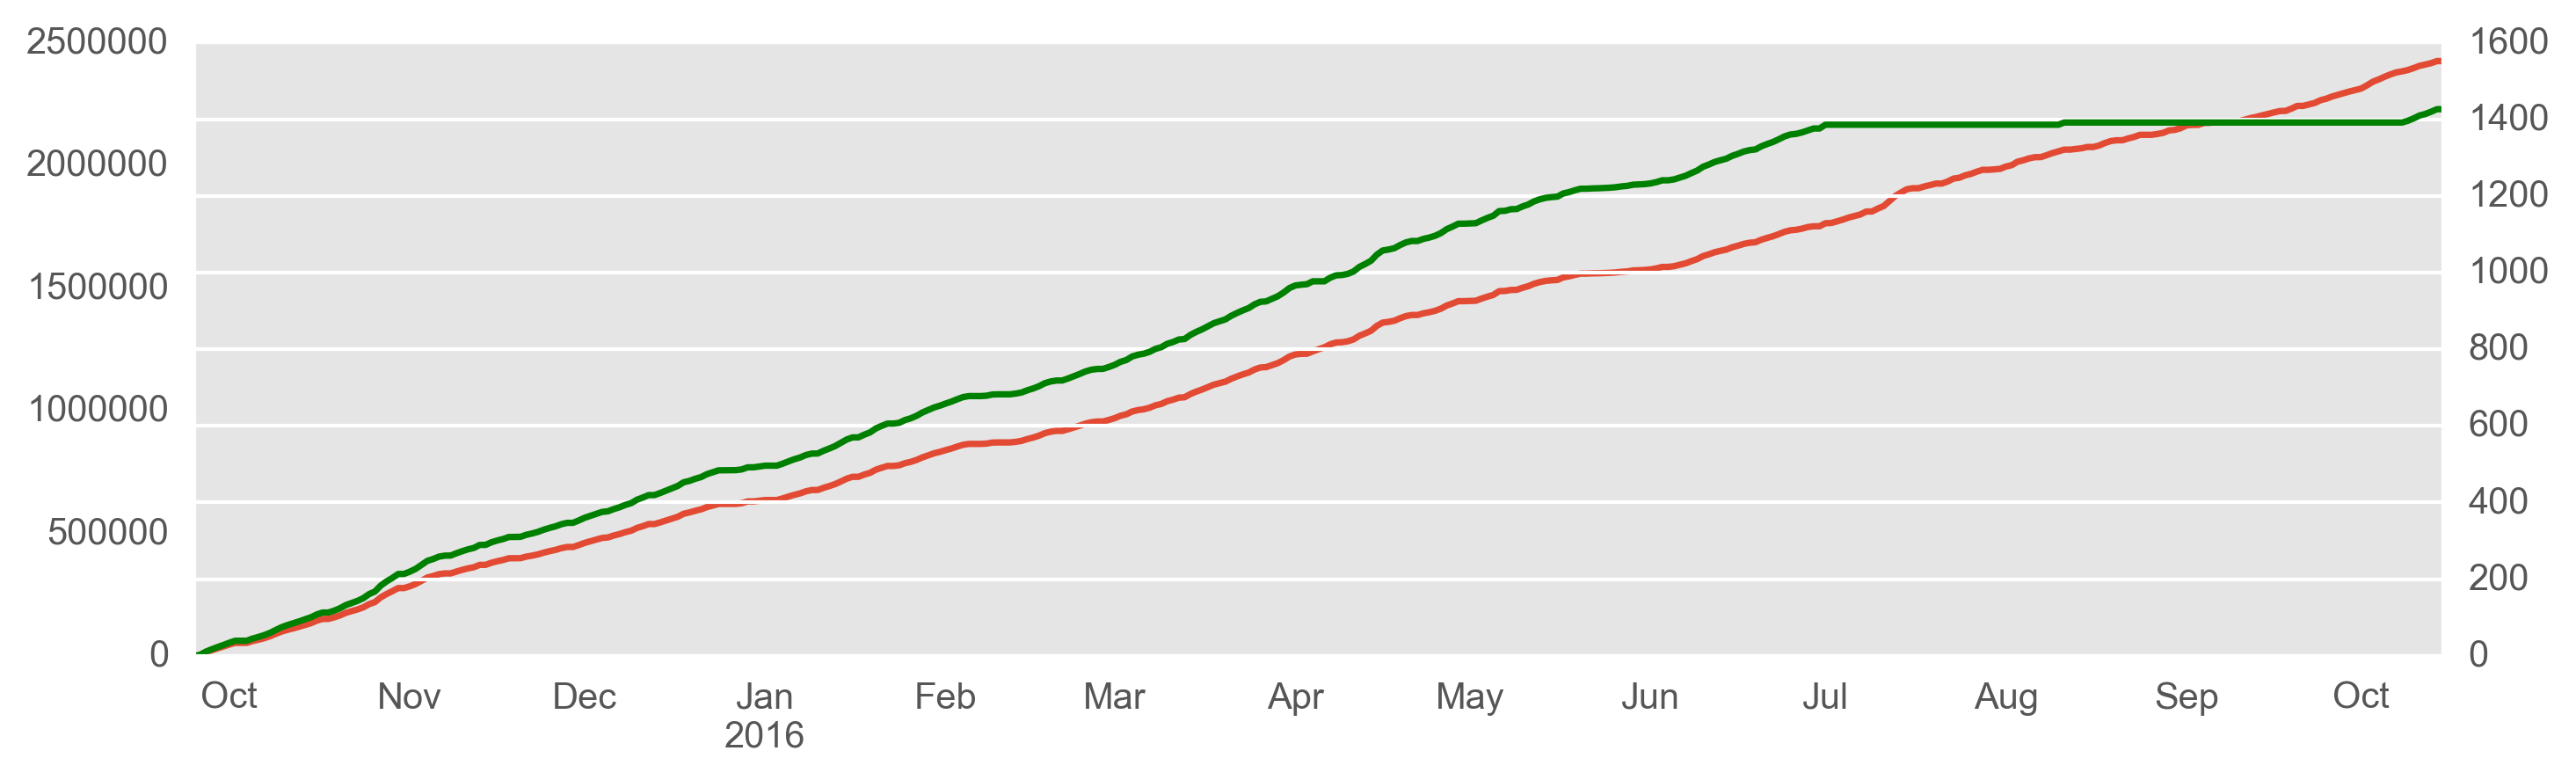

In [22]:
#Cumulative Charts
#Cumulative steps done
#Cumulative km walked
#Cumulative dataset

cumulative = data[['Steps (count)','Distance (km)','Flights Climbed (count)']].copy()
cumulative = cumulative.cumsum(axis=0, skipna=True)
cumulative = cumulative.fillna(method='ffill')
cumulative['Steps (count)'].plot(figsize=(11,3))
cumulative['Distance (km)'].plot(secondary_y=True, style='g')

In [64]:
#matrix charts histograms steps done per month
matrixdata = data_for_steps[['Steps (count)','Distance (km)','Flights Climbed (count)']].copy()
matrixdata['Month']=pd.to_datetime(matrixdata.index).month
matrixdata['Year']=pd.to_datetime(matrixdata.index).year

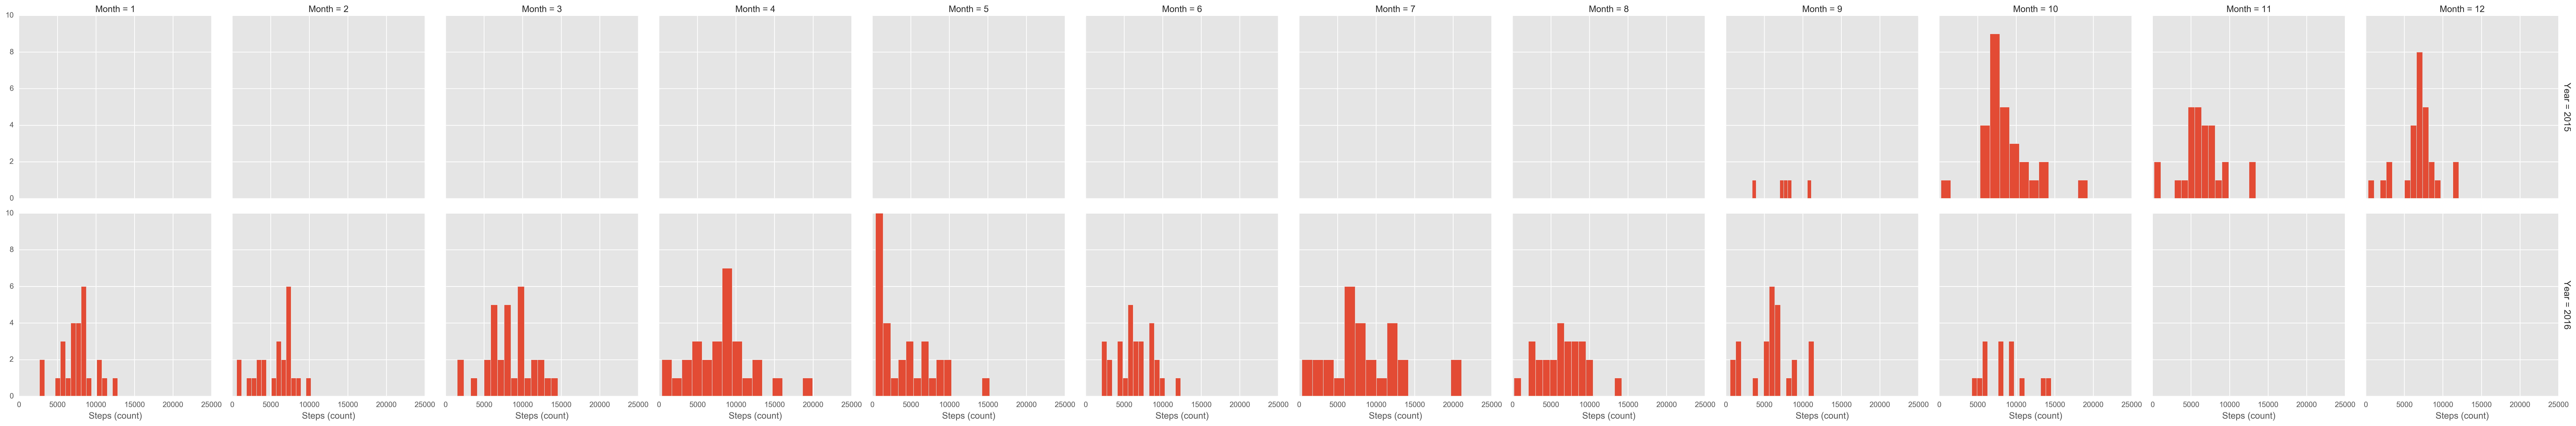

In [68]:
g = sns.FacetGrid(matrixdata, row="Year", col="Month", size=4, margin_titles=True)
g.map(plt.hist, "Steps (count)", bins=15)

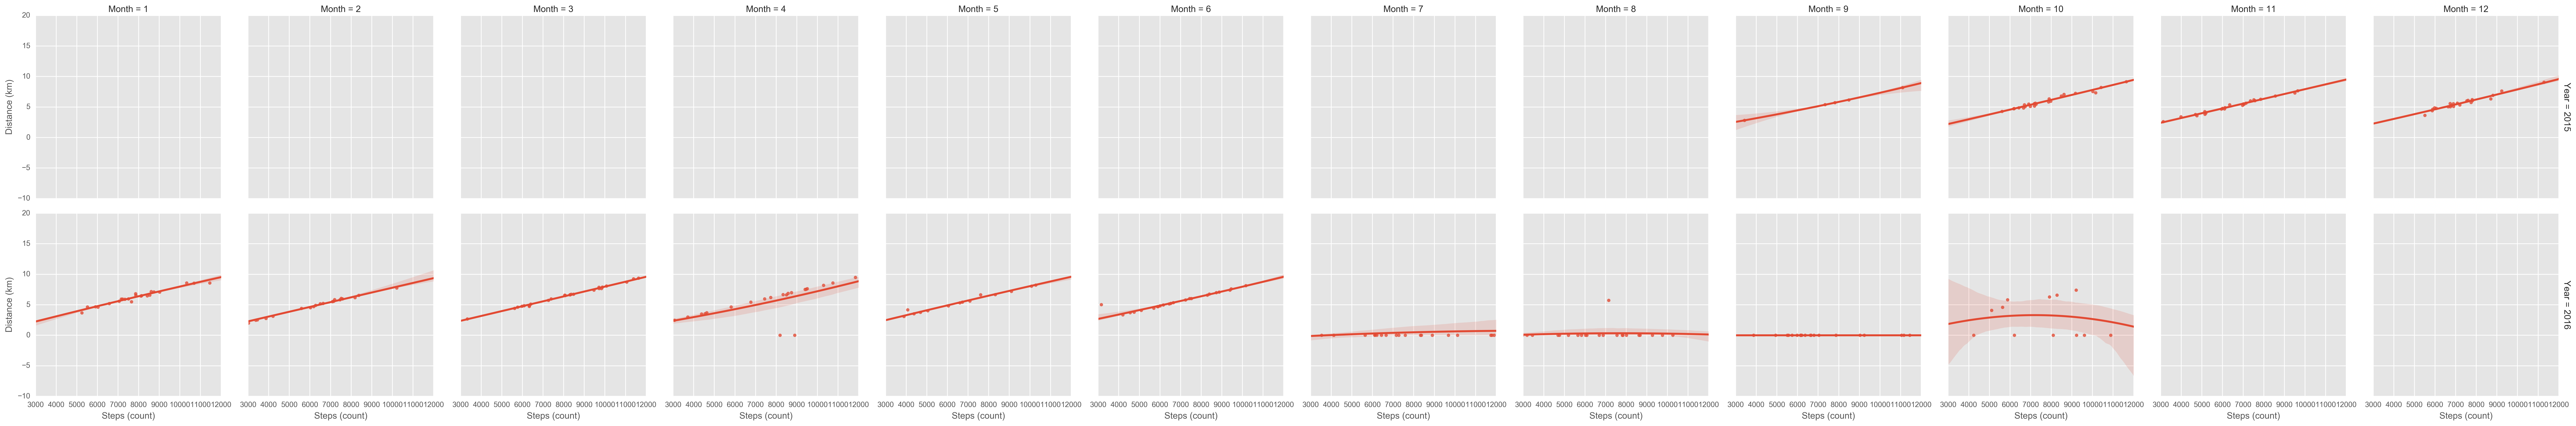

In [66]:
g = sns.FacetGrid(matrixdata, row="Year", col="Month", size=4, margin_titles=True)
g.map(sns.regplot, "Steps (count)", "Distance (km)", order=2)

In [ ]:
#boxplot for the weekday stats